In [11]:
import pandas as pd
import re
import gensim 
import mglearn
import numpy as np
import os
import matplotlib.pyplot as plt
from konlpy.utils import pprint
from konlpy.tag import Hannanum
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from konlpy.tag import Kkma, Twitter
import pyLDAvis.gensim
import pyLDAvis.sklearn
import collections
from gensim.models.word2vec import Word2Vec

class NaverAnalyzer():
    
        def __init__ (self):
            self.idx_result_df = pd.DataFrame()
            input_file_name = '/media/Data/Naver_News/result/indexing.txt'
            
            
            self.idx_result_df = pd.read_csv(input_file_name,header=None)
            self.filtered_idx_result_df = pd.DataFrame()
            self.idx_result_df.columns = ['date','title','content_url_list','file_list']
            
            self.climate_words = ["기후","온실가스","온난화","이산화탄소","탄소","폭설","폭우",
                                  "폭설","홍수","가뭄","혹서","혹한","해수면","열섬","이상고온","집중호우","해일","쓰나미","북극빙하","남극빙하",
                                  "히말라야빙하","그린란드빙하","사막화","녹색성장","태풍"]
            
            self.document_topics = None
            self.topic_words = None
            self.filtered_sentences = None
            self.w2v_model = None
            self.glove_model = None
            
            #디렉토리 생성
            dirname = 'result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')
      
            dirname = 'lda_result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')
                
            dirname = 'tm_result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')    
                
            self.idx_result_df['date'] = list(map(str, self.idx_result_df['date']))   
            dt_list = pd.to_datetime(self.idx_result_df['date'].tolist())
            self.idx_result_df['date'] =  dt_list.strftime("%Y-%m-%d").tolist()
            self.idx_result_df['file_list'] = list(map(lambda x: os.path.dirname(input_file_name) + "/" + os.path.basename(x), self.idx_result_df['file_list'].tolist()))
            
            self.filtered_idx_result_df =  self.idx_result_df  
            
        def filtering_date(self,start_date = None, end_date = None):
            dt_index = pd.date_range(start=start_date, end = end_date)
            dt_list = dt_index.strftime("%Y-%m-%d").tolist()
       
            idx = list(map(lambda x: x in dt_list, self.idx_result_df['date'].tolist()))
            self.filtered_idx_result_df = self.filtered_idx_result_df.iloc[idx]
            self.filtered_idx_result_df = self.filtered_idx_result_df.reset_index(drop=True)
            #print(self.idx_result_df[self.idx_result_df['date'] in dt_list])
        
        def trend_analysis(self, prefix="", norm=False):     
            dt_list = self.filtered_idx_result_df['date'].tolist()
            dt_cnt = collections.Counter(list(map(lambda x : x.split("-")[0], dt_list)))
            # = list(b)
            x = list(dt_cnt.keys())
            y = list(dt_cnt.values())
            print(x)
            print(y)
            
            if(norm == True) :
                dt_index = pd.date_range(start=min(dt_list), end = max(dt_list))
                all_dt_list = dt_index.strftime("%Y-%m-%d").tolist()
                idx = list(map(lambda x: x in all_dt_list, self.idx_result_df['date'].tolist()))
                temp_df = self.idx_result_df.iloc[idx]
                temp_df = temp_df.reset_index(drop=True)
                
                all_dt_cnt = collections.Counter(list(map(lambda x : x.split("-")[0], all_dt_list)))
                
                all_y = list(all_dt_cnt.values())
                
                y =  np.array(y) / np.array(all_y)
                y =  y.tolist()
                
            plt.xticks(rotation=50)
            plt.plot(x,y,c="b", lw=3, ls="--", marker="o", ms=10, mec="g", mew=3, mfc="r")
            plt.savefig("./" + prefix + "trends.png",dpi=200)

            
        def filtering_contents(self,rexp):
            
            file_list =  self.filtered_idx_result_df['file_list'].tolist()
            #print(file_list)
            fidx = []
            for i in range(len(file_list)):
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()
                p = re.compile(rexp)

                ridx = p.search(doc)

                if(ridx == None):
                   #print("없음")
                    continue
                fidx.append(i)
            #print(fidx)
            self.filtered_idx_result_df = self.filtered_idx_result_df.iloc[fidx]
            self.filtered_idx_result_df = self.filtered_idx_result_df.reset_index(drop=True)
            #print(self.idx_result_df)
        
        def reflect_result(self):
            self.idx_result_df = self.filtered_idx_result_df
            
        def save_filtered_result(self):
            self.idx_result_df.to_csv("./result/findexing.txt",header=None,index=None)
        
        def topic_modeling(self,n_topics,postfix="",use_title = False, is_pa=True):
            
            # 형태소 분석을 기본적으로 수행 
            
            if is_pa == True :
                file_list = self.filtered_idx_result_df['file_list'].tolist()
                title_list = self.filtered_idx_result_df['title'].tolist()
                #print(file_list)
                corpus = []
                
                # 형태소 분석기 선택
                #kkma = Kkma()
                kkma = Twitter()
                
                # 파일 내용 읽어서 코퍼스에 저장 
                
                for i in range(len(file_list)):
                    if(use_title == False):
                        f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                        doc = f.read()                       
                        corpus.append(" ".join(kkma.nouns(doc)))
                    else :
                        doc = title_list[i]
                        corpus.append(" ".join(kkma.nouns(doc)))

                #print(corpus)

                # Stop words ,
                stop_words = ["전략", "연구", "평가", "마련", "조사", "관리", "보다", "분석", "구축","개발","정책","대책",
                              "관련","전문가","예정","이번","환경부", "환경", "기술", "사업", "산업", "기업","우리나라", "또한",
                              "총회", "대한", "통해", "한국","국내","개최","행사","우수","서울","장관","호남권","피해","해외","일자리","박람회",
                              "지원", "위해", "총회","국제","분야","환경기술"]
                vect = CountVectorizer(stop_words = stop_words,ngram_range=(1, 2),min_df=0.005,max_df=0.3)
                X = vect.fit_transform(corpus)
                X = TfidfTransformer().fit_transform(X)

                #vect = CountVectorizer(stop_words = stop_words,min_df=0.005,max_df=0.3)
         
            n_words = 20
            for i in n_topics:
                lda = LatentDirichletAllocation(n_components = i,learning_method="batch",random_state=1)
                #lda = LatentDirichletAllocation(learning_method="batch")
                self.document_topics = lda.fit_transform(X)
                
                sorting = np.argsort(lda.components_, axis=1)[:,::-1]
                feature_names = np.array(vect.get_feature_names())
                #mglearn.tools.print_topics(topics=range(i), feature_names = feature_names, sorting=sorting, topics_per_chunk=20, n_words=20)
            
                self.filtered_idx_result_df["topic"] = np.argmax(self.document_topics,axis=1).tolist()
                self.topic_words = pd.DataFrame(feature_names[sorting])
                self.topic_words = self.topic_words.T
                self.topic_words = self.topic_words[:n_words]
                # 파일이름 접두사
                prefix = "./tm_result/result_n_" + str(i) + "_" + str(postfix)
                
                # 파일 저장 
                self.save_result(prefix)
                self.topic_modeling_vis(lda, X, vect,"result_n_" + str(i) + "_" + str(postfix) + "_")
        
        def topic_modeling_vis(self,lda,dtm,vect,prefix):
            pyldavis = pyLDAvis.sklearn.prepare(lda, dtm,vect)
            pyLDAvis.save_html(pyldavis,"./lda_vis/" + prefix + "lda.html")
                               
        def save_result(self,prefix):
            self.idx_result_df.to_csv(prefix + "_document_topic.csv",header=None,index=False)
            self.topic_words.to_csv(prefix + "_topic_words.csv",header=None,index=False)
            
        def select_topic_by_keywords(self,topics,proprtions=0.3):
            topic_list = self.filtered_idx_result_df['topic'].tolist()
            self.filtered_idx_result_df = self.filtered_idx_result_df.iloc[list(map(lambda x: x in topics, topic_list)),:]
            self.filtered_idx_result_df = self.filtered_idx_result_df.reset_index(drop=True)
            
        def select_topic(self,topics):
            topic_list = self.filtered_idx_result_df['topic'].tolist()
            self.filtered_idx_result_df = self.filtered_idx_result_df.iloc[list(map(lambda x: x in topics, topic_list)),:]
            self.filtered_idx_result_df = self.filtered_idx_result_df.reset_index(drop=True)
            
        def keyword_analysis(self,num,is_tfidf = True,is_noun=True):
            file_list = self.filtered_idx_result_df['file_list'].tolist()
            print(len(file_list))
            print("Keyword Analysis")
            corpus = []
            num = 100
            
            # 형태소 분석기 선택
            #kkma = Kkma()
            kkma = Twitter()

            # 파일 내용 읽어서 코퍼스에 저장 

            for i in range(len(file_list)):
                #print(i)
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()                       
                corpus.append(" ".join(kkma.nouns(doc)))

            stop_words = []
                    
            vect = CountVectorizer(stop_words = stop_words,ngram_range=(1, 2),min_df=0.005,max_df=0.3)
            #ocab = vectorizer.get_feature_names()
            
            X = vect.fit_transform(corpus)
            if(is_tfidf == True):
                X = TfidfTransformer().fit_transform(X)
                
            count = X.toarray().sum(axis=0)
            idx = np.argsort(-count)
            count = count[idx]
     
            feature_name = np.array(vect.get_feature_names())[idx]
            plt.bar(range(len(count)), count)
            plt.show()
            
            pprint(list(zip(feature_name[:num], count[:num])))
            
        def extract_sentence(self,rexp):
            file_list =  self.filtered_idx_result_df['file_list'].tolist()
            filtered_sentences= []
            for i in range(len(file_list)):
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()
                sentences = self.split_text(doc)
                
                for s in sentences :
                    p = re.compile(rexp)
                    ridx = p.search(s)

                    if(ridx == None):
                       #print("없음")
                        continue
                    s = s.strip()
                    s = re.sub('[^가-힝0-9a-zA-Z\\s]', '', s)
                    filtered_sentences.append(s.strip())
            self.filtered_sentences = filtered_sentences
            
        def sentence_keyword_analysis(self,is_tfidf=False):
            kkma = Twitter()
            corpus = []
            
            for s in self.filtered_sentences:               
                corpus.append(" ".join(kkma.nouns(s)))

            # Stop words ,
            stop_words = ["전략", "연구", "평가", "마련", "조사", "관리", "보다", "분석", "구축","개발","정책","대책",
                          "관련","전문가","예정","이번","환경부", "환경", "기술", "사업", "산업", "기업","우리나라", "또한",
                          "총회", "대한", "통해", "한국","국내","개최","행사","우수","서울","장관","호남권","피해","해외","일자리","박람회",
                          "지원", "위해", "총회","국제","분야","환경기술"]
                    
            vect = CountVectorizer(stop_words = stop_words,ngram_range=(1, 2),min_df=0.005,max_df=0.3)
            #ocab = vectorizer.get_feature_names()
            X = vect.fit_transform(corpus)
            if(is_tfidf == True):
                X = TfidfTransformer().fit_transform(X)
            count = X.toarray().sum(axis=0)
            idx = np.argsort(-count)
            count = count[idx]
     
            feature_name = np.array(vect.get_feature_names())[idx]
            plt.bar(range(len(count)), count)
            plt.show()
            
            pprint(list(zip(feature_name, count)))
            
        def training_keyword_w2v(self):
            file_list = self.filtered_idx_result_df['file_list'].tolist()
            #print(file_list)
            corpus = []

            # 형태소 분석기 선택
            #kkma = Kkma()
            kkma = Twitter()

            # 파일 내용 읽어서 코퍼스에 저장 

            for i in range(len(file_list)):
                #print(i)
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()                       
                corpus.append(kkma.nouns(doc))
           
            model = Word2Vec(corpus)
            model.init_sims(replace=True)
            self.w2v_model = model
        
        def print_w2v_words(self,word,num=30):
            print(self.w2v_model.most_similar(word),num)
            print(self.w2v_model.predict_output_word(word, topn=10))
            
        def keyword_glove(self,text):
            new_text = text.replace(".",".\n").replace("?","?\n").replace("!","!\n")
            sentences = new_text.splitlines()
            return sentences    
        
        def keyword_association_analysis(self,text):
            new_text = text.replace(".",".\n").replace("?","?\n").replace("!","!\n")
            sentences = new_text.splitlines()
            return sentences    
            
        def split_text(self,text):
            new_text = text.replace(".",".\n").replace("?","?\n").replace("!","!\n")
            sentences = new_text.splitlines()
            return sentences 
                           
        def combine_result(self,s):
            print("AA")
       

In [26]:
na = NaverAnalyzer()
na.filtering_date('2017-11-01','2017-12-31')
na.filtered_idx_result_df.tail(3)

#ma.keyword_analysis("기후")
#ma.extract_sentence("기후변화")
#ma.sentence_keyword_analysis()

#ma.filtering_contents("기후변화")

#ma.topic_modeling([20],"s1")
#ma.select_topic([1])
#ma.filtered_idx_result_df


#ma.topic_modeling([40],"s1")

#ma.filtered_idx_result_df
#ma.topic_words

,date,title,content_url_list,file_list
7525,2017-12-31,충북 중남부권역 초미세먼지 주의보 해제,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171231_98.txt
7526,2017-12-31,"올해 마지막 날, 낮부터 맑음…해넘이·해돋이 본다",http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171231_99.txt
7527,2017-12-31,미세먼지 비상저감조치 첫 발령···현장에선 ‘일단 준수’,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171231_100.txt


In [28]:
na.training_keyword_w2v()

In [30]:
na.print_w2v_words(u'미세먼지')

[('농도', 0.7748427987098694), ('이산화질소', 0.7355719804763794), ('대기', 0.7338281869888306), ('정소', 0.7306656241416931), ('초미세먼지', 0.7281261682510376), ('권역', 0.715535581111908), ('감', 0.7024314999580383), ('황사', 0.7018114328384399), ('대기오염', 0.6905408501625061), ('비상', 0.6858946084976196)] 30
[('만', 0.0003359806), ('마리', 0.00032396748), ('세', 0.00031127094), ('천', 0.00030456655), ('약', 0.00029392267), ('여', 0.00029018454), ('명', 0.00026666984), ('이상', 0.00026370294), ('만원', 0.00026175848), ('그루', 0.0002530753)]


['2017']
[7528]


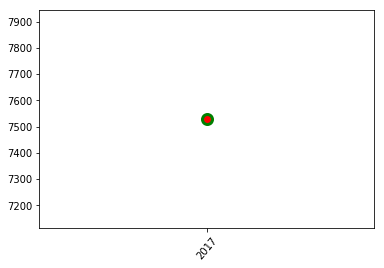

In [32]:
na.trend_analysis("all")

['2017']
[111]


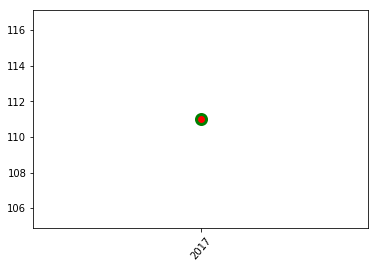

In [34]:
# 키워드 트랜드 분석
na = NaverAnalyzer()
na.filtering_date('2017-11-01','2017-12-31')
na.filtering_contents("쓰레기")
na.trend_analysis("climate", False)

111
Keyword Analysis


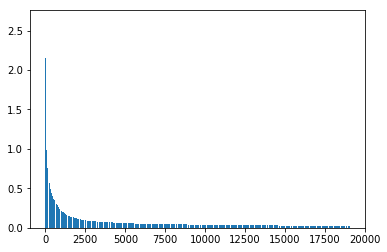

[('종량제', 2.6256406503683554),
 ('수거', 2.4953508779729314),
 ('뉴시스', 2.4532638608658117),
 ('영상', 2.2681316859844745),
 ('발전소', 2.154588980009295),
 ('사진 영상', 2.151333008267892),
 ('환경부', 2.0927852234278026),
 ('뉴스', 1.9108933256693903),
 ('해양', 1.9060306034320544),
 ('나주', 1.8515818391055718),
 ('산불', 1.84377253949281),
 ('병합', 1.8210765656882506),
 ('봉투', 1.8091551013789584),
 ('시행', 1.7973311681405502),
 ('병합 발전소', 1.7949212417754787),
 ('시민', 1.7361045518690148),
 ('미세먼지', 1.6566434949601094),
 ('요일', 1.6542055247050824),
 ('공사', 1.6479025696275866),
 ('시설', 1.6306162576365075),
 ('제주', 1.6023689014778522),
 ('연료', 1.5579801516357983),
 ('관리', 1.5207729827710121),
 ('지침', 1.498757672938776),
 ('개정', 1.4868981197502402),
 ('수수료', 1.48144279508882),
 ('요일 배출', 1.4730736342309516),
 ('시행 지침', 1.462404768856722),
 ('세종', 1.433000580549844),
 ('쓰레기 수거', 1.4079870299990362),
 ('쓰레기 수수료', 1.3665649648429241),
 ('수수료 종량제', 1.3665649648429241),
 ('종량제 봉투', 1.3605968877484684),
 ('쓰레기 연료', 1.

In [35]:
# TF-IDF 기준
na.keyword_analysis(200)

In [37]:
# 기후 관련 문장 추출

na = NaverAnalyzer()
na.filtering_date('2017-11-01','2017-12-31')
na.filtered_idx_result_df.tail(3)
na.extract_sentence("기후")
na.filtered_sentences

['세종뉴시스 승진 1급 폐기물관리처장 강문식 환경인증검사처장 이준기 수도권동부지역본부 자원순환관리처장 박민규 호남권지역본부 환경시설관리처장 추연홍 2급 폐자원에너지처 폐자원시설검사팀장 주경규 환경시설처 민자관리팀장 최철규 부산울산경남지역본부 자원순환관리처 자원순환사업팀장 이재철 대기환경처 유해대기관리팀장 송보윤 기후변화대응처 배출권총괄팀장 오승환 자원순환처 재활용성평가팀장 고인표 환경에너지시설처 에너지설계팀장 송장환 수도권서부지역본부 환경시설관리처 공사관리3팀장 김병국 ijoinonnewsis',
 '행정안전부 제공행안부 관계자는 한파 사망자는 기후적 요인뿐만 아니라 인구 구조적으로도 취약한 지역에서 많이 발생한다면서 한파 위험지수가 높은 지역에서는 동절기 취약계층 보호를 위해 종합 지원센터 보호시설 등을 운영하는 등 한파 피해 예방활동이 필요하다고 말했다',
 '뉴질랜드 기후변화 난민 대비전용비자 발급 논의',
 'AFP뉴스12050년까지 세계 기후난민 최대 3억명 발생서울뉴스1 김진 기자  새롭게 취임한 재신더 아던 뉴질랜드 총리가 기후변화 난민 대책에 집중하고 있다',
 '아던 총리는 31일현지시간 취임 후 처음 가진 CNN 인터뷰에서 우리는 기후변화에 따른 난민들을 맞을 선두에 있다는 사실을 인정해야 할 필요가 있다며 이에 대비해야 한다고 밝혔다',
 '아던 총리는 우리는 기후변화를 국제적으로 인정하고 대응하는 것의 중요성뿐 아니라 우리 임무를 다하는 데 관심을 기울이고 있다며 기후변화에 대한 책임감을 키울 방법과 향후 기후 변화 난민들에게 접근하는 방식을 모색하고 있다고 설명했다',
 '이들은 기후변화로 해수면이 상승하면서 깨끗한 식수가 줄어들고 일자리를 구하지 못해 망명을 신청했다',
 '1951년 유엔 난민 협정은 기후변화 희생자들을 난민에 포함하지 않아서다',
 '제임스 쇼 기후변화 장관도 이날 기후 변화 난민들을 위한 최초의 비자 발급을 언급하며 어젠더에 힘을 실었다',
 '미국이주감시센터에 따르면 2050년까지 기후 변화로 인해 보금자리를 

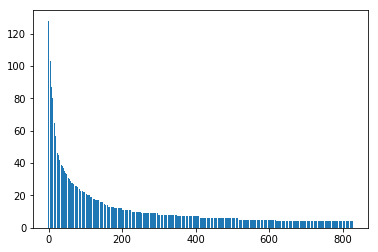

[('협약', 128),
 ('유엔', 122),
 ('파리', 122),
 ('기후변화 협약', 110),
 ('연합뉴스', 107),
 ('에너지', 103),
 ('독일', 96),
 ('대응', 94),
 ('당사', 87),
 ('협정', 84),
 ('기후변화 대응', 83),
 ('기자', 80),
 ('유엔 기후변화', 74),
 ('현지', 73),
 ('미국', 72),
 ('김은경', 66),
 ('협약 당사', 65),
 ('시장', 60),
 ('세계', 59),
 ('대표', 57),
 ('시간', 48),
 ('지난', 48),
 ('현지 시간', 47),
 ('온실가스', 47),
 ('센터', 46),
 ('정부', 46),
 ('파리 기후변화', 45),
 ('사무', 45),
 ('연설', 43),
 ('채권', 43),
 ('지속', 42),
 ('미래', 42),
 ('회의', 42),
 ('기조', 40),
 ('기조 연설', 39),
 ('협력', 39),
 ('기후 에너지', 39),
 ('기상청', 38),
 ('과장', 38),
 ('총장', 38),
 ('사무 총장', 37),
 ('호텔', 37),
 ('파리 협정', 37),
 ('탄소', 35),
 ('체제', 35),
 ('기구', 35),
 ('기후 채권', 34),
 ('국가', 33),
 ('독일 기후변화', 33),
 ('반기문', 33),
 ('변화', 32),
 ('자원', 32),
 ('이행', 32),
 ('지구', 32),
 ('대통령', 31),
 ('감축', 31),
 ('지역', 31),
 ('도시', 30),
 ('주제', 30),
 ('호텔 기후', 30),
 ('사국', 29),
 ('시간 독일', 29),
 ('포시즌스 호텔', 28),
 ('포시즌스', 28),
 ('종로구', 28),
 ('종로구 포시즌스', 28),
 ('중국', 28),
 ('계획', 28),
 ('기후변화 사국', 27),
 ('뉴스', 27),
 ('

In [38]:
na.sentence_keyword_analysis()

In [8]:
# 토픽 모델링
na = NaverAnalyzer()
na.filtering_date('2017-11-01','2017-12-31')
na.topic_modeling([5],"s1")
na.filtered_idx_result_df

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


,date,title,content_url_list,file_list,topic
0,2017-11-01,‘미세먼지 저감기술’ 업무협약 부산환경공단-신라대 손 잡아,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_0.txt,2
1,2017-11-01,내일 전국 흐리고 중부 비···서울 한낮 19도,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_1.txt,0
2,2017-11-01,강정고령보 남조류 '감소'…조류경보 해제되나,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_2.txt,2
3,2017-11-01,오토바이에 개 묶어 달린 60대 동물 학대 혐의 조사,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_3.txt,2
4,2017-11-01,금강환경청 미세먼지 유발 사업장 점검…환경법 위반 8곳 적발,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_4.txt,2
5,2017-11-01,[인사]한국환경공단,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_5.txt,2
6,2017-11-01,깊어가는 가을,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_6.txt,4
7,2017-11-01,저 멀리 가는 가을,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_7.txt,4
8,2017-11-01,눈부신 가을,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_8.txt,4
9,2017-11-01,대관령의 가을 정취,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_9.txt,4


In [12]:
# 토픽 모델링
na = NaverAnalyzer()
na.filtering_date('2017-11-01','2017-12-31')
na.topic_modeling([5],"s1",True)
na.filtered_idx_result_df

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


,date,title,content_url_list,file_list,topic
0,2017-11-01,‘미세먼지 저감기술’ 업무협약 부산환경공단-신라대 손 잡아,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_0.txt,4
1,2017-11-01,내일 전국 흐리고 중부 비···서울 한낮 19도,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_1.txt,4
2,2017-11-01,강정고령보 남조류 '감소'…조류경보 해제되나,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_2.txt,0
3,2017-11-01,오토바이에 개 묶어 달린 60대 동물 학대 혐의 조사,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_3.txt,0
4,2017-11-01,금강환경청 미세먼지 유발 사업장 점검…환경법 위반 8곳 적발,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_4.txt,4
5,2017-11-01,[인사]한국환경공단,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_5.txt,0
6,2017-11-01,깊어가는 가을,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_6.txt,1
7,2017-11-01,저 멀리 가는 가을,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_7.txt,1
8,2017-11-01,눈부신 가을,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_8.txt,1
9,2017-11-01,대관령의 가을 정취,http://news.naver.com/main/read.nhn?mode=LS2D&...,/media/Data/Naver_News/result/20171101_9.txt,3
